In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

['tensorflow_lstm_airlinePassengers.ipynb', 'airline-passengers.csv', 'pytorch_LSTM_airlinePassengers.ipynb', '.ipynb_checkpoints', 'tensorflow_2017commodityPrice.ipynb', 'pytorch_LSTM_POSTagging.ipynb', '.git', '2017commodityPrice.csv']


In [3]:
# Importing the training set
data = pd.read_csv('./airline-passengers.csv',skipfooter=2)
data.head()

/var/folders/58/hxkrgjd16yzcg36mh4h_qrjh0000gn/T/ipykernel_27911/3890738960.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv('./airline-passengers.csv',skipfooter=2)


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
data

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
137,1960-06,535
138,1960-07,622
139,1960-08,606
140,1960-09,508


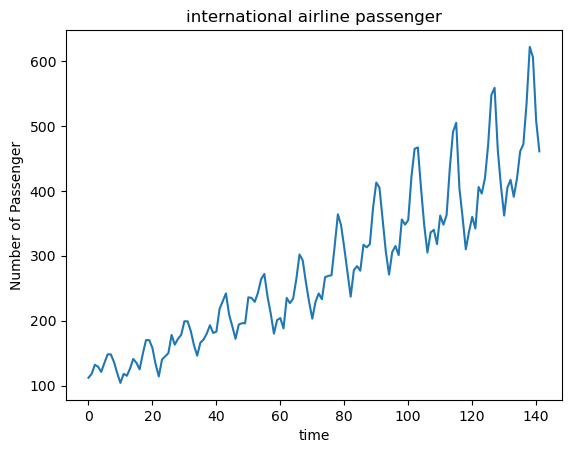

In [5]:
dataset = data.iloc[:,1].values
plt.plot(dataset)
plt.xlabel("time")
plt.ylabel("Number of Passenger")
plt.title("international airline passenger")
plt.show()

In [7]:
dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")
dataset.shape

(142, 1)

In [8]:
#Scaling
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [9]:
train_size = int(len(dataset) * 0.50)
test_size = len(dataset)- train_size 
train = dataset[0:train_size,:]
test = dataset [train_size:len(dataset),:]
print("train size: {}, test size: {} ".format(len(train),len(test)))

train size: 71, test size: 71 


# BUILDING THE RNN

In [10]:
time_stemp = 10
dataX = []
dataY = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = np.array(dataX)
trainY = np.array(dataY) 

In [11]:
trainX

array([[0.01544401, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
        0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753],
       [0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984557,
        0.08494207, 0.08494207, 0.06177607, 0.02895753, 0.        ],
       [0.05405405, 0.04826255, 0.03281853, 0.05984557, 0.08494207,
        0.08494207, 0.06177607, 0.02895753, 0.        , 0.02702703],
       [0.04826255, 0.03281853, 0.05984557, 0.08494207, 0.08494207,
        0.06177607, 0.02895753, 0.        , 0.02702703, 0.02123553],
       [0.03281853, 0.05984557, 0.08494207, 0.08494207, 0.06177607,
        0.02895753, 0.        , 0.02702703, 0.02123553, 0.04247104],
       [0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753,
        0.        , 0.02702703, 0.02123553, 0.04247104, 0.07142857],
       [0.08494207, 0.08494207, 0.06177607, 0.02895753, 0.        ,
        0.02702703, 0.02123553, 0.04247104, 0.07142857, 0.05984557],
       [0.08494207, 0.06177607, 0.0289575

In [12]:
trainY

array([0.        , 0.02702703, 0.02123553, 0.04247104, 0.07142857,
       0.05984557, 0.04054055, 0.08687258, 0.12741312, 0.12741312,
       0.10424709, 0.05598456, 0.01930502, 0.06949806, 0.07915059,
       0.08880308, 0.14285713, 0.11389962, 0.13127413, 0.14285713,
       0.18339768, 0.18339768, 0.15444016, 0.11196911, 0.08108109,
       0.1196911 , 0.12934363, 0.14671814, 0.17181468, 0.14864865,
       0.15250966, 0.22007722, 0.24324325, 0.26640925, 0.2027027 ,
       0.16795367, 0.13127413, 0.17374519, 0.17760617, 0.17760617,
       0.25482625, 0.25289574, 0.24131274, 0.26833975, 0.3088803 ,
       0.32432434, 0.25675675, 0.20656371, 0.14671814, 0.18725869,
       0.19305018, 0.16216215, 0.25289574, 0.23745173, 0.25096524,
       0.3088803 , 0.38223937, 0.36486486, 0.2992278 , 0.24131274],
      dtype=float32)

In [26]:
trainY.shape

(60,)

In [13]:
dataX = []
dataY = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = np.array(dataX)
testY = np.array(dataY)  

In [14]:
testX

array([[0.24131274, 0.26640925, 0.24903473, 0.31467178, 0.3185328 ,
        0.32046333, 0.4073359 , 0.5019305 , 0.46911195, 0.40154442],
       [0.26640925, 0.24903473, 0.31467178, 0.3185328 , 0.32046333,
        0.4073359 , 0.5019305 , 0.46911195, 0.40154442, 0.32818535],
       [0.24903473, 0.31467178, 0.3185328 , 0.32046333, 0.4073359 ,
        0.5019305 , 0.46911195, 0.40154442, 0.32818535, 0.25675675],
       [0.31467178, 0.3185328 , 0.32046333, 0.4073359 , 0.5019305 ,
        0.46911195, 0.40154442, 0.32818535, 0.25675675, 0.3359073 ],
       [0.3185328 , 0.32046333, 0.4073359 , 0.5019305 , 0.46911195,
        0.40154442, 0.32818535, 0.25675675, 0.3359073 , 0.34749034],
       [0.32046333, 0.4073359 , 0.5019305 , 0.46911195, 0.40154442,
        0.32818535, 0.25675675, 0.3359073 , 0.34749034, 0.33397684],
       [0.4073359 , 0.5019305 , 0.46911195, 0.40154442, 0.32818535,
        0.25675675, 0.3359073 , 0.34749034, 0.33397684, 0.41119692],
       [0.5019305 , 0.46911195, 0.4015444

In [15]:
testY

array([0.32818535, 0.25675675, 0.3359073 , 0.34749034, 0.33397684,
       0.41119692, 0.4034749 , 0.4131274 , 0.52123547, 0.5965251 ,
       0.58108103, 0.484556  , 0.3899614 , 0.3223938 , 0.3899614 ,
       0.4073359 , 0.3803089 , 0.48648646, 0.47104248, 0.484556  ,
       0.6138996 , 0.6969112 , 0.70077217, 0.57915056, 0.46911195,
       0.38803086, 0.44787642, 0.45559844, 0.4131274 , 0.4980695 ,
       0.47104248, 0.49999997, 0.6389961 , 0.7471043 , 0.7741313 ,
       0.57915056, 0.492278  , 0.3976834 , 0.44980696, 0.49420848,
       0.45945945, 0.5830116 , 0.5637065 , 0.61003864, 0.71042466,
       0.8571429 , 0.8783784 , 0.69305015, 0.5849421 , 0.4980695 ,
       0.58108103, 0.6042471 , 0.554054  , 0.60810804, 0.6891892 ,
       0.71042466, 0.8320464 , 1.        , 0.96911204, 0.7799227 ],
      dtype=float32)

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [25]:
# Creating LSTM Model 
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, time_stemp))) # 50 lstm neuron(block)
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='Adamax')
    model.fit(trainX, trainY, epochs=250, batch_size=4)

Epoch 1/250
15/15 [==============================] - 1s 920us/step - loss: 0.0330
Epoch 2/250
15/15 [==============================] - 0s 876us/step - loss: 0.0168
Epoch 3/250
 1/15 [=>............................] - ETA: 0s - loss: 0.0115

2023-05-28 15:46:24.173390: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x28d20d2c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-28 15:46:24.173404: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-05-28 15:46:24.190916: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-28 15:46:24.332722: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 0s 1ms/step - loss: 0.0089
Epoch 4/250
15/15 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 5/250
15/15 [==============================] - 0s 991us/step - loss: 0.0044
Epoch 6/250
15/15 [==============================] - 0s 966us/step - loss: 0.0040
Epoch 7/250
15/15 [==============================] - 0s 821us/step - loss: 0.0039
Epoch 8/250
15/15 [==============================] - 0s 783us/step - loss: 0.0038
Epoch 9/250
15/15 [==============================] - 0s 781us/step - loss: 0.0037
Epoch 10/250
15/15 [==============================] - 0s 856us/step - loss: 0.0037
Epoch 11/250
15/15 [==============================] - 0s 879us/step - loss: 0.0036
Epoch 12/250
15/15 [==============================] - 0s 852us/step - loss: 0.0036
Epoch 13/250
15/15 [==============================] - 0s 854us/step - loss: 0.0035
Epoch 14/250
15/15 [==============================] - 0s 832us/step - loss: 0.0034
Epoch 15/250
15/15 [=======

Epoch 102/250
15/15 [==============================] - 0s 739us/step - loss: 0.0016
Epoch 103/250
15/15 [==============================] - 0s 897us/step - loss: 0.0015
Epoch 104/250
15/15 [==============================] - 0s 909us/step - loss: 0.0015
Epoch 105/250
15/15 [==============================] - 0s 861us/step - loss: 0.0015
Epoch 106/250
15/15 [==============================] - 0s 866us/step - loss: 0.0016
Epoch 107/250
15/15 [==============================] - 0s 788us/step - loss: 0.0016
Epoch 108/250
15/15 [==============================] - 0s 862us/step - loss: 0.0015
Epoch 109/250
15/15 [==============================] - 0s 822us/step - loss: 0.0015
Epoch 110/250
15/15 [==============================] - 0s 928us/step - loss: 0.0015
Epoch 111/250
15/15 [==============================] - 0s 660us/step - loss: 0.0015
Epoch 112/250
15/15 [==============================] - 0s 879us/step - loss: 0.0015
Epoch 113/250
15/15 [==============================] - 0s 839us/step - loss:

In [27]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# inverting predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

2/2 [==============================] - 0s 12ms/step


2023-05-28 15:50:17.745850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-28 15:50:17.782547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step
Train Score: 16.081 RMSE
Test Score: 37.752 RMSE


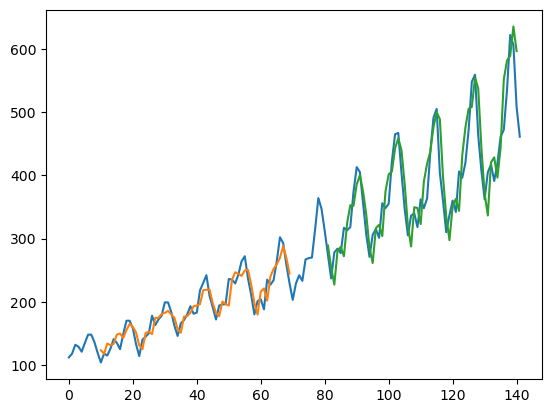

In [28]:
# shifting train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict
# shifting test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()